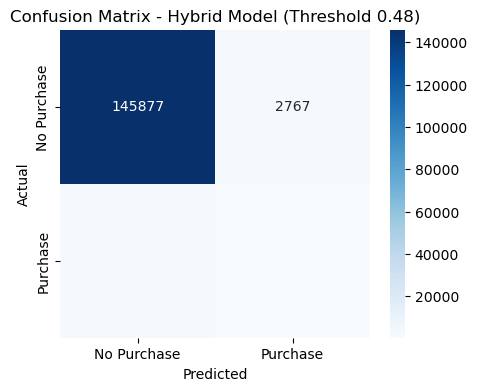

Hybrid Model Accuracy: 0.9642

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    148644
           1       0.14      0.15      0.15      3133

    accuracy                           0.96    151777
   macro avg       0.56      0.57      0.56    151777
weighted avg       0.96      0.96      0.96    151777


Confusion Matrix:
 [[145877   2767]
 [  2666    467]]

Final Weights Used → XGBoost: 0.65, Random Forest: 0.35


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Load Dataset
df = pd.read_csv("Google Analytics Demo Sales.csv")

# Data Preprocessing
df['date'] = pd.to_datetime(df['date'])  # Convert date column to datetime format
df['country'] = df['country'].fillna('Unknown')  # Handle missing values

# Create Target Variable (1 = Purchase, 0 = Not Purchase)
df['target'] = df['type'].apply(lambda x: 1 if x == 'purchase' else 0)

# Feature Engineering (Extract Useful Features)
df['hour'] = df['date'].dt.hour  # Extract hour of the day
df['day_of_week'] = df['date'].dt.dayofweek  # Extract day of the week (0 = Monday, 6 = Sunday)

# Encode Categorical Variables
label_encoders = {}
for col in ['country', 'device']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoders for future use

# Define Feature Set & Target
features = ['country', 'device', 'hour', 'day_of_week']
X = df[features]
y = df['target']

# Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Model
xgb_model = XGBClassifier(eval_metric='logloss', scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]))
xgb_model.fit(X_train, y_train)

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Get Probability Predictions from Both Models
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]  # Probability of purchase from XGBoost
rf_probs = rf_model.predict_proba(X_test)[:, 1]  # Probability of purchase from Random Forest

# Adjusted Balanced Weights (XGBoost 65%, RF 35%)
xgb_weight = 0.65
rf_weight = 0.35

# Compute Final Probabilities Using Adjusted Weights
final_probs = (xgb_weight * xgb_probs) + (rf_weight * rf_probs)

# Apply Raised Threshold (Now 0.48 Instead of 0.45)
final_preds = (final_probs > 0.48).astype(int)

# Evaluate Model Performance
accuracy = accuracy_score(y_test, final_preds)
report = classification_report(y_test, final_preds)

# Confusion Matrix
cm = confusion_matrix(y_test, final_preds)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Purchase', 'Purchase'], yticklabels=['No Purchase', 'Purchase'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Hybrid Model (Threshold 0.48)')
plt.show()

# Print Results
print(f"Hybrid Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:\n", cm)
print(f"\nFinal Weights Used → XGBoost: {xgb_weight}, Random Forest: {rf_weight}")